### Import Libraries

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
import os
import cv2
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Load Pre-trained autoencoder

In [21]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # --- Encoder ---
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=4, stride=2, padding=1),  # (B, 16, 128, 128)
            nn.ReLU()
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),  # (B, 32, 64, 64)
            nn.ReLU()
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # (B, 64, 32, 32)
            nn.ReLU()
        )

        # --- Decoder ---
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # (B, 32, 64, 64)
            nn.ReLU()
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(64, 16, kernel_size=4, stride=2, padding=1),  # (B, 16, 128, 128)
            nn.ReLU()
        )
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),   # (B, 1, 256, 256)
            nn.Sigmoid()  # for binary mask reconstruction
        )

    def forward(self, x):
        # --- Encoding ---
        x1 = self.enc1(x)  # (B, 16, 128, 128)
        x2 = self.enc2(x1) # (B, 32, 64, 64)
        x3 = self.enc3(x2) # (B, 64, 32, 32)

        # --- Decoding ---
        d3 = self.dec3(x3)           # (B, 32, 64, 64)
        d3 = torch.cat([d3, x2], 1)  # (B, 64, 64, 64)

        d2 = self.dec2(d3)           # (B, 16, 128, 128)
        d2 = torch.cat([d2, x1], 1)  # (B, 32, 128, 128)

        out = self.dec1(d2)          # (B, 1, 256, 256)
        return out


In [22]:
# Reconstruct the model and optimizer exactly as before
autoencoder = Autoencoder().to(device)  # match your original config
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

# Load checkpoint
checkpoint = torch.load("autoencoder_checkpoint.pth", map_location=torch.device(device))  # use 'cuda' if needed
autoencoder
# Restore weights and optimizer state
autoencoder.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']
last_loss = checkpoint['loss']

autoencoder.eval()  # or model.train() if resuming training

print(f"Loaded model from epoch {start_epoch} with loss {last_loss:.4f}")


Loaded model from epoch 70 with loss 0.0032


In [23]:
def extract_coordinates_from_heatmap(heatmap_tensor, threshold=0.8, center=None, degrees=True):
    heatmap = heatmap_tensor.squeeze().cpu().numpy()  # (H, W)
    H, W = heatmap.shape
    binary = (heatmap > threshold).astype(np.uint8)

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)

    if center is None:
        center = (W // 2, H // 2)

    cx, cy = center
    polar_coords = []

    for i in range(1, num_labels):  # skip background
        x, y = centroids[i]
        dx, dy = x - cx, y - cy
        radius = np.sqrt(dx**2 + dy**2)
        angle = np.arctan2(dy, dx)
        if degrees:
            angle = np.degrees(angle) % 360 # Convert to degrees and normalize to [0, 360)
        polar_coords.append((radius, angle))  # Normalize angle to [0, 1]

    # Sort by radius (distance from center)
    polar_coords.sort(key=lambda x: x[0])

    return polar_coords

Detected corners: [(np.float64(52.9963893482435), np.float64(168.26601111148227)), (np.float64(63.146592607386204), np.float64(165.4315019843729)), (np.float64(70.65740783289121), np.float64(246.96112340170006)), (np.float64(72.73158337307561), np.float64(307.3913337407501)), (np.float64(89.66621462597533), np.float64(71.77192898482285))]
Length: 5


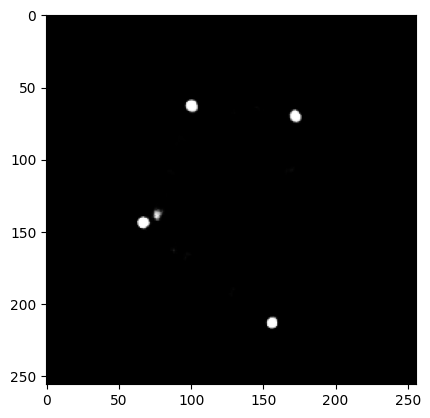

In [24]:
def predict_image(image_path):
    # Load and preprocess image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)  # (1, H, W)
    img = np.expand_dims(img, axis=0)  # (1, 1, H, W)
    img_tensor = torch.tensor(img).to(device)

    autoencoder.eval()
    with torch.no_grad():
        output = autoencoder(img_tensor)
        heatmap = output[0]  # (1, H, W)
        corner_coords = extract_coordinates_from_heatmap(heatmap, threshold=0.75)
        print("Detected corners:", corner_coords)
        print("Length:", len(corner_coords))

    output_img = output.cpu().squeeze().numpy()
    return output_img

# Example usage:
result_img = predict_image("synthetic_dataset_complex\sample_0999\img1.png")
plt.imshow(result_img, cmap="gray")
plt.show()

Detected corners: [(np.float64(63.06139703430592), np.float64(297.23260097450355)), (np.float64(70.54695143509643), np.float64(18.99393886778743)), (np.float64(73.14064544848165), np.float64(79.63615036793678)), (np.float64(89.42094050441676), np.float64(203.74020854265464))]
Length: 4


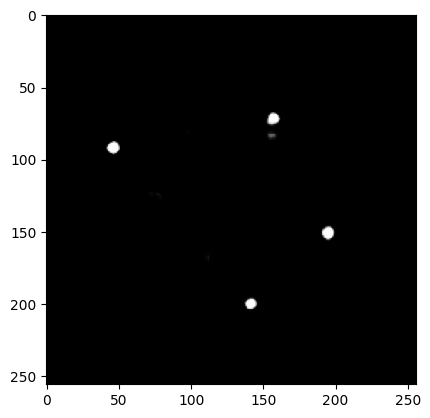

In [25]:
def predict_image(image_path):
    # Load and preprocess image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)  # (1, H, W)
    img = np.expand_dims(img, axis=0)  # (1, 1, H, W)
    img_tensor = torch.tensor(img).to(device)

    autoencoder.eval()
    with torch.no_grad():
        output = autoencoder(img_tensor)
        heatmap = output[0]  # (1, H, W)
        corner_coords = extract_coordinates_from_heatmap(heatmap, threshold=0.75)
        print("Detected corners:", corner_coords)
        print("Length:", len(corner_coords))

    output_img = output.cpu().squeeze().numpy()
    return output_img

# Example usage:
result_img = predict_image("synthetic_dataset_complex\sample_0999\img2.png")
plt.imshow(result_img, cmap="gray")
plt.show()

In [26]:
def match_point_sets(list1, list2, return_diff=False, max_points=16):
    arr1 = np.array(list1, dtype=np.float64)
    arr2 = np.array(list2, dtype=np.float64)

    if arr1.ndim != 2 or arr2.ndim != 2 or arr1.shape[1] != 2 or arr2.shape[1] != 2:
        # Handle empty or malformed input
        arr1 = np.zeros((0, 2), dtype=np.float64)
        arr2 = np.zeros((0, 2), dtype=np.float64)

    arr1 = arr1[arr1[:, 0].argsort()]
    arr2 = arr2[arr2[:, 0].argsort()]

    if len(arr1) > len(arr2):
        arr1, arr2 = arr2, arr1

    matched1 = []
    matched2 = []
    used = set()

    for p1 in arr1:
        r1, a1 = p1
        dists = np.abs(arr2[:, 0] - r1)
        for idx in np.argsort(dists):
            if idx not in used:
                matched1.append((r1, a1))
                matched2.append((arr2[idx][0], arr2[idx][1]))
                used.add(idx)
                break

    while len(matched1) < max_points:
        matched1.append((0.0, 0.0))
        matched2.append((0.0, 0.0))

    if return_diff:
        return [(r1 - r2, a1 - a2) for (r1, a1), (r2, a2) in zip(matched1, matched2)]
    else:
        return matched1, matched2

In [27]:
l1 = [(np.float64(63.06139703430592), np.float64(297.23260097450355)), (np.float64(70.54695143509643), np.float64(18.99393886778743)), (np.float64(73.14064544848165), np.float64(79.63615036793678)), (np.float64(89.42094050441676), np.float64(203.74020854265464))]
l2 = [(np.float64(52.9963893482435), np.float64(168.26601111148227)), (np.float64(63.146592607386204), np.float64(165.4315019843729)), (np.float64(70.65740783289121), np.float64(246.96112340170006)), (np.float64(72.73158337307561), np.float64(307.3913337407501)), (np.float64(89.66621462597533), np.float64(71.77192898482285))]

match_point_sets(l1, l2, return_diff=True)

[(np.float64(-0.08519557308028425), np.float64(131.80109899013067)),
 (np.float64(-0.11045639779477767), np.float64(-227.96718453391264)),
 (np.float64(0.409062075406041), np.float64(-227.75518337281332)),
 (np.float64(-0.2452741215585661), np.float64(131.9682795578318)),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0)]

## Train Regression Model

Load dataset

In [ ]:
class AutoencoderDataset(Dataset):
    def __init__(self, root_dir, image_type1="img1.png", image_type2="img2.png", transform=None):
        self.root_dir = root_dir
        self.sample_dirs = sorted([
            os.path.join(root_dir, d) for d in os.listdir(root_dir)
            if os.path.isdir(os.path.join(root_dir, d))
        ])
        self.image_type1 = image_type1
        self.image_type2 = image_type2
        self.transform = transform

    def __len__(self):
        return len(self.sample_dirs)

    def __getitem__(self, idx):
        sample_path = self.sample_dirs[idx]
        img1_path = os.path.join(sample_path, self.image_type1)
        img2_path = os.path.join(sample_path, self.image_type2)

        img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
        img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0

        img1 = np.expand_dims(img1, axis=0)  # (1, H, W)
        img2 = np.expand_dims(img2, axis=0)  # (1, H, W)

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        img1 = torch.tensor(img1, dtype=torch.float32)
        img2 = torch.tensor(img2, dtype=torch.float32)

        # Load and convert angle
        angle_path = os.path.join(sample_path, "angle.txt")
        if os.path.exists(angle_path):
            with open(angle_path, "r") as f:
                angle = float(f.read().strip())
                # make angle always positive
                ang = abs(np.sin(np.deg2rad(angle)))
            angle_tensor = torch.tensor(ang, dtype=torch.float32)
        else:
            raise FileNotFoundError(f"{angle_path} not found.")

        return img1, img2, angle_tensor

Split train and validation sets

In [29]:
dataset = AutoencoderDataset(root_dir="synthetic_dataset_complex")

# Define split ratio
val_ratio = 0.2  # 20% for validation
total_size = len(dataset)
val_size = int(total_size * val_ratio)
train_size = total_size - val_size

# Randomly split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Quick check on loader

In [30]:
for img1, img2, angle in train_loader:
    print(img1.shape, img2.shape, angle.shape)
    break

torch.Size([32, 1, 256, 256]) torch.Size([32, 1, 256, 256]) torch.Size([32])


Define model

In [31]:
def extract_coordinates_from_heatmap(heatmap_tensor, threshold=0.8, center=None, degrees=True):
    heatmap = heatmap_tensor.squeeze().cpu().numpy()  # (H, W)
    H, W = heatmap.shape
    binary = (heatmap > threshold).astype(np.uint8)

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)

    if center is None:
        center = (W // 2, H // 2)

    cx, cy = center
    polar_coords = []

    for i in range(1, num_labels):  # skip background
        x, y = centroids[i]
        dx, dy = x - cx, y - cy
        radius = np.sqrt(dx**2 + dy**2)
        angle = np.arctan2(dy, dx)
        if degrees:
            angle = np.degrees(angle) % 360 # Convert to degrees and normalize to [0, 360)
        polar_coords.append((radius, angle))  # Normalize angle to [0, 1]

    # Sort by radius (distance from center)
    polar_coords.sort(key=lambda x: x[0])

    return polar_coords


def match_point_sets(list1, list2, return_diff=False, max_points=16):
    arr1 = np.array(list1, dtype=np.float64)
    arr2 = np.array(list2, dtype=np.float64)

    if arr1.ndim != 2 or arr2.ndim != 2 or arr1.shape[1] != 2 or arr2.shape[1] != 2:
        arr1 = np.zeros((0, 2), dtype=np.float64)
        arr2 = np.zeros((0, 2), dtype=np.float64)

    arr1 = arr1[arr1[:, 0].argsort()]
    arr2 = arr2[arr2[:, 0].argsort()]

    if len(arr1) > len(arr2):
        arr1, arr2 = arr2, arr1

    matched1 = []
    matched2 = []
    used = set()

    for p1 in arr1:
        r1, a1 = p1
        dists = np.abs(arr2[:, 0] - r1)
        for idx in np.argsort(dists):
            if idx not in used:
                matched1.append((r1, a1))
                matched2.append((arr2[idx][0], arr2[idx][1]))
                used.add(idx)
                break

    while len(matched1) < max_points:
        matched1.append((0.0, 0.0))
        matched2.append((0.0, 0.0))

    if return_diff:
        return [(r1 - r2, abs(math.sin(math.radians(a1 - a2)))) for (r1, a1), (r2, a2) in zip(matched1, matched2)]
    else:
        return matched1, matched2

In [32]:
class Regressor(nn.Module):
    def __init__(self, autoencoder, max_points=16):
        super(Regressor, self).__init__()
        self.encoder = autoencoder
        self.max_points = max_points

        self.regressor = nn.Sequential(
            nn.Linear(max_points * 2, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def extract_polar_coords(self, x):
        self.encoder.eval()
        with torch.no_grad():
            heatmap = self.encoder(x)[0][0]  # shape: (1, H, W)

        polar_coords = extract_coordinates_from_heatmap(
            heatmap, threshold=0.75, degrees=True
        )

        # Sort and convert angle to sin(θ)
        polar_coords = sorted(polar_coords, key=lambda p: p[0])
        polar_coords = [(r, a) for r, a in polar_coords]

        return polar_coords

    def forward(self, x1, x2):
        batch_size = x1.size(0)
        outputs = []

        for i in range(batch_size):
            coords1 = self.extract_polar_coords(x1[i].unsqueeze(0))
            coords2 = self.extract_polar_coords(x2[i].unsqueeze(0))

            # Get difference vector only
            diffs = match_point_sets(coords1, coords2, return_diff=True, max_points=self.max_points)

            # Convert to tensor
            diff_tensor = torch.tensor(diffs, dtype=torch.float32, device=x1.device).flatten()
            outputs.append(diff_tensor)

        features = torch.stack(outputs, dim=0)  # (B, max_points * 2)
        sin_pred = self.regressor(features).squeeze(1)  # (B,)
        return sin_pred

Hyper parameters

In [33]:
num_epochs = 40
learning_rate = 1e-3

model = Regressor(autoencoder=autoencoder).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Quick test on model

In [ ]:
model.train()

# Get one batch
for img1, img2, target_sin in train_loader:
    img1 = img1.to(device)
    img2 = img2.to(device)
    target_sin = target_sin.to(device)

    optimizer.zero_grad()

    # Forward pass
    pred_sin = model(img1, img2)

    # Print predictions and targets
    print("Predicted sin(angle):", pred_sin.detach().cpu().numpy())
    print("Target sin(angle):   ", target_sin.detach().cpu().numpy())

    # Compute loss
    loss = criterion(pred_sin, target_sin)
    print(f"Loss: {loss.item():.6f}")

    # Backprop
    loss.backward()
    optimizer.step()

    break  # Just test one batch


Predicted sin(angle): [0.36242247 0.17890845 0.20127444 0.19509277 0.34060568 0.18108653
 0.19285744 0.17276019 0.16024074 0.19875138 0.17374687 0.3034175
 0.16103885 0.17029253 0.1947535  0.15765493 0.17107476 0.16583869
 1.4930651  0.17927516 0.18189837 0.16104713 0.24825999 1.112885
 0.16996166 0.21893907 0.20392257 0.18459705 0.15353514 0.1814269
 0.17422265 0.17136389]
Target sin(angle):    [0.39828095 0.12503092 0.19894227 0.98657745 0.99814284 0.1651657
 0.80509555 0.73438936 0.27858955 0.9989848  0.41984212 0.64172685
 0.9996741  0.57389474 0.8361135  0.53700686 0.7176399  0.5974777
 0.6191634  0.751292   0.8899443  0.57503176 0.8260363  0.9933142
 0.01650792 0.17193504 0.919763   0.81584114 0.69185597 0.73800725
 0.31821737 0.7563031 ]
Loss: 0.265633


Train the model

In [35]:
model.train()

for epoch in range(1, num_epochs + 1):
    total_train_loss = 0.0

    for img1, img2, target_sin in train_loader:
        img1 = img1.to(device)
        img2 = img2.to(device)
        target_sin = target_sin.to(device)

        optimizer.zero_grad()

        # Forward pass
        pred_sin = model(img1, img2)
        loss = criterion(pred_sin, target_sin)

        # Backward + optimize
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * img1.size(0)

    avg_train_loss = total_train_loss / len(train_loader.dataset)

    # -------------------------
    # Validation
    # -------------------------
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for img1, img2, target_sin in val_loader:
            img1 = img1.to(device)
            img2 = img2.to(device)
            target_sin = target_sin.to(device)

            pred_sin = model(img1, img2)
            val_loss = criterion(pred_sin, target_sin)

            total_val_loss += val_loss.item() * img1.size(0)

    avg_val_loss = total_val_loss / len(val_loader.dataset)

    # -------------------------
    # Logging
    # -------------------------
    print(f"Epoch [{epoch}/{num_epochs}] - Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}\n")

    model.train()  # back to train mode


Epoch [1/40] - Train Loss: 0.242934 | Val Loss: 0.145696

Epoch [2/40] - Train Loss: 0.104039 | Val Loss: 0.042923

Epoch [3/40] - Train Loss: 0.048342 | Val Loss: 0.034412

Epoch [4/40] - Train Loss: 0.037296 | Val Loss: 0.030356

Epoch [5/40] - Train Loss: 0.031735 | Val Loss: 0.026523

Epoch [6/40] - Train Loss: 0.027901 | Val Loss: 0.023850

Epoch [7/40] - Train Loss: 0.024703 | Val Loss: 0.021590

Epoch [8/40] - Train Loss: 0.022246 | Val Loss: 0.020071

Epoch [9/40] - Train Loss: 0.019903 | Val Loss: 0.018473

Epoch [10/40] - Train Loss: 0.018052 | Val Loss: 0.017516

Epoch [11/40] - Train Loss: 0.016616 | Val Loss: 0.016605

Epoch [12/40] - Train Loss: 0.015455 | Val Loss: 0.016125

Epoch [13/40] - Train Loss: 0.014412 | Val Loss: 0.015463

Epoch [14/40] - Train Loss: 0.013604 | Val Loss: 0.015344

Epoch [15/40] - Train Loss: 0.013108 | Val Loss: 0.015619

Epoch [16/40] - Train Loss: 0.012711 | Val Loss: 0.014409

Epoch [17/40] - Train Loss: 0.012141 | Val Loss: 0.014882

Epoch 

save model for future use

In [49]:
# Save the trained regressor model and optimizer state
save_path = "regressor_checkpoint.pth"
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss.item(),
}, save_path)
print(f"Model saved to {save_path}")

Model saved to regressor_checkpoint.pth


Quick validation

In [45]:
# Set model to train mode
model.eval()

# Get one batch
for img1, img2, target_sin in val_loader:
    img1 = img1.to(device)
    img2 = img2.to(device)
    target_sin = target_sin.to(device)

    optimizer.zero_grad()

    # Forward pass
    pred_sin = model(img1, img2)

    # Print predictions and targets
    print("Predicted sin(angle):", pred_sin.detach().cpu().numpy())
    print("Target sin(angle):   ", target_sin.detach().cpu().numpy())

    # Compute loss
    loss = criterion(pred_sin, target_sin)
    print(f"Loss: {loss.item():.6f}")

    # Backprop
    loss.backward()
    optimizer.step()

    break  # Just test one batch


Predicted sin(angle): [0.9288186  0.715096   0.6826155  0.5892995  0.19294569 0.4205793
 0.6947396  0.6965374  0.6418415  0.8314353  1.0433773  0.6494738
 0.965242   0.6097441  0.8697081  0.88934785 0.72226834 0.18093586
 0.9690845  0.42696524 0.11926773 1.035015   1.0809798  0.69185126
 0.84391725 0.10949025 0.13993803 0.7306948  1.0320096  0.90602326
 1.0435666  0.23117271]
Target sin(angle):    [0.8444729  0.67799723 0.6099028  0.54161114 0.17169821 0.4046464
 0.689502   0.66566664 0.61674905 0.9118132  0.9599513  0.6751295
 0.9201357  0.61277276 0.8338348  0.86438    0.6716339  0.24072495
 0.9909794  0.399772   0.07235783 0.9854501  0.9992762  0.7402945
 0.95877373 0.03746409 0.11192022 0.7248968  0.96695375 0.91759735
 0.99990815 0.13713485]
Loss: 0.002867


Inference 

In [46]:
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)  # (1, H, W)
    img = np.expand_dims(img, axis=0)  # (1, 1, H, W)
    return torch.tensor(img, dtype=torch.float32).to(device)

def predict_angle_from_images(path1, path2, model, show=True):
    model.eval()

    # Load and preprocess
    img1 = preprocess_image(path1)
    img2 = preprocess_image(path2)

    with torch.no_grad():
        pred_sin = model(img1, img2).item()

    # Clip to valid range just in case
    pred_sin = max(-1.0, min(1.0, pred_sin))

    # Convert sin(θ) → θ (in degrees)
    angle_rad = math.asin(pred_sin)
    angle_deg = math.degrees(angle_rad)

    # Normalize to [0, 360)
    angle_deg = angle_deg % 360

    print(f"Predicted angle: {angle_deg:.2f}° (sin value: {pred_sin:.4f})")

    if show:
        img1_np = cv2.imread(path1, cv2.IMREAD_GRAYSCALE)
        img2_np = cv2.imread(path2, cv2.IMREAD_GRAYSCALE)

        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        axs[0].imshow(img1_np, cmap='gray')
        axs[0].set_title("Image 1")
        axs[0].axis('off')

        axs[1].imshow(img2_np, cmap='gray')
        axs[1].set_title("Image 2")
        axs[1].axis('off')

        plt.suptitle(f"Predicted Angle: {angle_deg:.2f}°", fontsize=14)
        plt.tight_layout()
        plt.show()

    return angle_deg


Predicted angle: 90.00° (sin value: 1.0000)


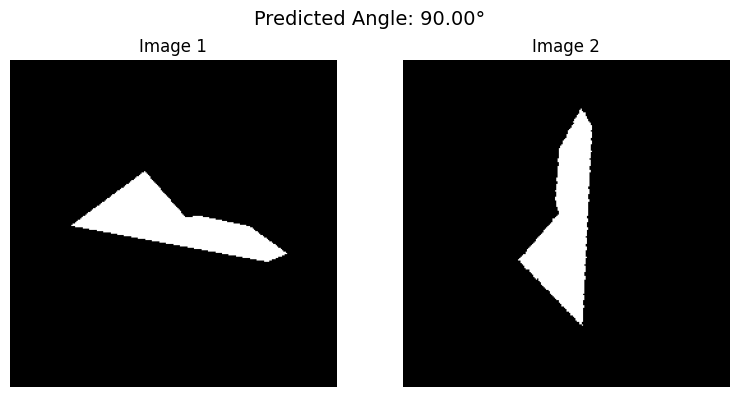

In [48]:
angle = predict_angle_from_images(
    "synthetic_dataset_complex/sample_0002/img1.png",
    "synthetic_dataset_complex/sample_0002/img2.png",
    model
)
